In [2]:
from Shingling import Shingling
from CompareSets import CompareSets
from MinHashing import MinHashing
from CompareSignatures import compare_signatures
from lsh import *
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

## PARAMETERS

In [3]:
THRESHOLD = 0.8
K = 5
BANDS = 20
ROWS_PER_BAND = 5
NUM_HASHES = 100

## Read data

In [4]:
path = 'dataset/SMSSpamCollection'
df = pd.read_csv(path, sep='\t', header=None, names=['Label', 'Message'])
df_cleaned = df[df['Message'].str.len() >= K].copy() # Remove documents that are shorter than our shingle length to avoid empty elements in the set
df_cleaned.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
len(df_cleaned)

5554

## Compute the similarities between all sets of shingles using Jaccard Similarity

In [5]:
def get_array_of_hashed_shingle_sets(k, docs):
    shingle_hashes = []
    for document in docs:
        shingling_instance = Shingling(document, k)
        shingle_hashes.append(shingling_instance.shingle_hashes)
    return shingle_hashes

In [6]:
def get_similarities(docs):
    similarities = []
    shingle_hashes = get_array_of_hashed_shingle_sets(4, docs)

    start_time_no_optimisation = time.time()
    for i in range(len(docs)-1):
        t1 = shingle_hashes[i]
        for j in range(i+1, len(docs)):
            t2 = shingle_hashes[j]
            similarity = CompareSets(t1, t2)
            similarities.append(similarity)
    end_time_no_optimisation = time.time()

    duration_no_optimisation = end_time_no_optimisation - start_time_no_optimisation
    return similarities, duration_no_optimisation

similarities, _ = get_similarities(df_cleaned['Message'])

KeyboardInterrupt: 

While this procedure gives an accurate measurement of distance between documents, it is computationally expensive and has high time complexity. Lets optimize the computations by approximating the similarities between signatures of documents using MinHashing

## MinHashing

In [8]:
shingle_hashes = get_array_of_hashed_shingle_sets(K, df_cleaned['Message'])
min_hash_instance = MinHashing(NUM_HASHES)
hej = min_hash_instance.get_signature(shingle_hashes[0])
min_hashes = np.array([min_hash_instance.get_signature(token) for token in shingle_hashes])
print(len(hej))

100


In [9]:
print(hej)

[2422694, 83533, 531315, 108961, 1040811, 1438324, 917421, 141035, 80850, 643957, 399709, 1617997, 187399, 149669, 1582324, 1247367, 231197, 335090, 2872146, 89659, 509610, 284856, 1357223, 1140475, 1046010, 4266236, 302679, 2044227, 982767, 1992870, 2516171, 813122, 925035, 354556, 1272934, 4663782, 157283, 199610, 2781295, 532698, 2233226, 807804, 353187, 311600, 145299, 441119, 613626, 1801028, 4151507, 686631, 123735, 4628646, 168721, 1170172, 1130234, 477491, 774738, 2234386, 1011460, 4468753, 3829309, 1573620, 253017, 767538, 558500, 1690125, 81026, 3142047, 339863, 47885, 380664, 1897081, 1807786, 836708, 231951, 432795, 140597, 893073, 61844, 2556980, 500852, 152016, 2431710, 360693, 758487, 2089656, 182104, 324579, 177894, 71870, 1450638, 4755722, 1100164, 1872144, 86391, 920561, 95395, 779603, 376405, 2744261]


Mean Absolute Error between actual and approximate similarities: 0.0063920554743258666


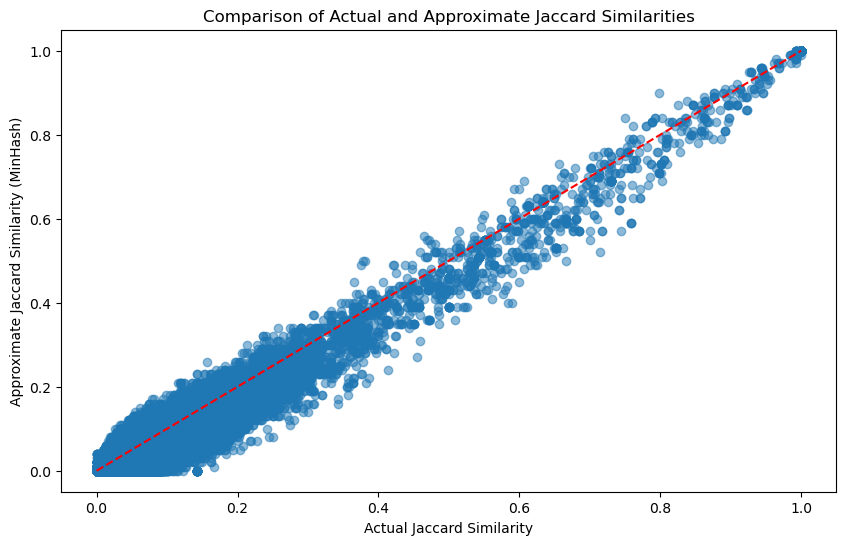

In [ ]:
approx_similarities = []

for i in range(len(min_hashes) - 1):
    for j in range(i + 1, len(min_hashes)):
        approx_similarity = compare_signatures(min_hashes[i], min_hashes[j])
        approx_similarities.append(approx_similarity)

error = mean_absolute_error(similarities, approx_similarities)

print(f"Mean Absolute Error between actual and approximate similarities: {error}")

plt.figure(figsize=(10, 6))
plt.scatter(similarities, approx_similarities, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlabel("Actual Jaccard Similarity")
plt.ylabel("Approximate Jaccard Similarity (MinHash)")
plt.title("Comparison of Actual and Approximate Jaccard Similarities")
plt.show()

In [9]:
print(len(min_hashes))
print(len(similarities))

5554
15420681


We have now approximated the jaccard similarities. We can see that the error between approximations and actual similarities is very low, and we have reduced the required computation heavily. Lets continue with LSH

## Execution time vs size of the input for LSH compared to computationally expensive similarity computation

In [6]:
def calculate_approx_similarities(docs):
    start = time.time()
    shingle_hashes = get_array_of_hashed_shingle_sets(K, docs)
    min_hash_instance = MinHashing(NUM_HASHES)
    min_hashes = np.array([min_hash_instance.get_signature(token) for token in shingle_hashes])
    lsh_instance = lsh(min_hashes, THRESHOLD, BANDS, ROWS_PER_BAND)
    approx_similar_pairs = lsh_instance.filter_candidate_pairs()
    exec_time = time.time() - start
    return approx_similar_pairs, exec_time

def calculate_similarities(docs):
    similarities = []
    shingle_hashes = get_array_of_hashed_shingle_sets(K, docs)

    start_time_no_optimisation = time.time()
    for i in range(len(docs)-1):
        t1 = shingle_hashes[i]
        for j in range(i+1, len(docs)):
            t2 = shingle_hashes[j]
            similarity = CompareSets(t1, t2)
            if similarity >= THRESHOLD:
                similarities.append(similarity)

    duration_no_optimisation = time.time() - start_time_no_optimisation
    return similarities, duration_no_optimisation

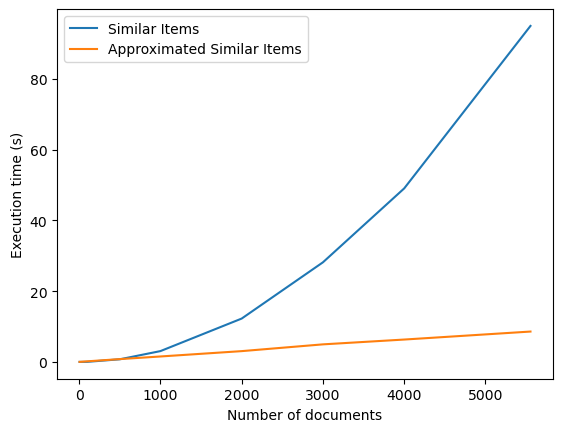

In [7]:

random_generator = np.random.default_rng(seed=1)
documents_size = [5, 10, 100, 500, 1000, 2000, 3000, 4000, len(df_cleaned)]
approx_exec_times = []
list_approx_pairs = []
exec_times = []
list_pairs = []

for n in documents_size:
    subset = random_generator.choice(df_cleaned['Message'], n)

    approx_similar_pairs, approx_exec_time = calculate_approx_similarities(subset)
    list_approx_pairs.append(approx_similar_pairs)
    approx_exec_times.append(approx_exec_time)

    similar_pairs, exec_time = calculate_similarities(subset) 
    list_pairs.append(similar_pairs)
    exec_times.append(exec_time)
    

plt.plot(documents_size, exec_times, label='Similar Items')
plt.plot(documents_size, approx_exec_times, label='Approximated Similar Items')
plt.xlabel('Number of documents')
plt.ylabel('Execution time (s)')
plt.legend()
plt.show()

In [9]:
true_positives = 0
false_positives = 0
spam_indices = set(df_cleaned[df_cleaned['Label'] == 'spam'].index)
actual_spam_pairs = {(i, j) for i in spam_indices for j in spam_indices if i < j}
for (i, j, _) in approx_similar_pairs:
    label_i = df_cleaned.iloc[i]['Label']
    label_j = df_cleaned.iloc[j]['Label']
    
    if label_i == 'spam' and label_j == 'spam':
        true_positives += 1
    else:
        false_positives += 1
    
    # Remove true positives from actual_spam_pairs to calculate false negatives later
    if (i, j) in actual_spam_pairs:
        actual_spam_pairs.remove((i, j))

# Step 4: Count remaining pairs in actual_spam_pairs as false negatives
false_negatives = len(actual_spam_pairs)

# Step 5: Print results
print("True Positives:", true_positives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)

True Positives: 86
False Positives: 3925
False Negatives: 278566
